In [1]:
import local_models.local_models
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.cluster
import sklearn.svm
from importlib import reload
from ml_battery.utils import cmap
import matplotlib as mpl
import sklearn.datasets
import sklearn.decomposition
import logging
import ml_battery.log
import time
import os
import functools
import collections
import joblib
import local_models.loggin
import local_models.TLS_models
import local_models.utils
from local_models.TLS_models import LinearRegression, QuadraticRegression, SphericalRegression, LinearODR
from sklearn import datasets, svm, metrics

logger = logging.getLogger(__name__)

np.random.seed(1)
#reload(local_models.loggin)
#reload(local_models.TLS_models)
np.warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [136]:
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
font = {'size'   : 18}

mpl.rc('font', **font)

In [3]:
digits = datasets.load_digits()

In [154]:
mnist = sklearn.datasets.fetch_openml('mnist_784')

In [158]:
mnist.data.shape, mnist.target.shape

((70000, 784), (70000,))

In [4]:
RUN = 2
project_dir = "../data/local_svm_mnist_{:02d}".format(RUN)
os.makedirs(project_dir, exist_ok=1)

In [5]:
images_and_labels = list(zip(digits.images, digits.target))

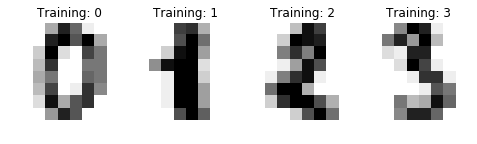

In [6]:
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Training: %i' % label)

In [7]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

In [8]:
SEED=1
train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(
    data, digits.target, test_size=0.3, random_state=SEED)

In [35]:
model = sklearn.svm.LinearSVC(C=1., dual=False)
linear_models = local_models.local_models.LocalModels(model)
linear_models.fit(train_data, train_labels)

In [10]:
dz, iz = linear_models.index.query(train_data, k=2)

In [11]:
avg_1nn_dist = np.average(dz[:,1])

In [12]:
kernel = local_models.local_models.GaussianKernel(bandwidth=avg_1nn_dist*20)

In [13]:
train_data.shape

(1257, 64)

In [14]:
train_labels.shape

(1257,)

In [15]:
def linear_reject_pointwise_bases(x, bases, mean=0):
    x = x - mean #mean center everything
    projection = local_models.utils.linear_project_pointwise_bases(x, bases)
    rejection = x - projection
    rejection = rejection + mean #re-add the mean in
    return rejection

def scms(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None):
    #all_failures = []
    
    timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=iters, tag="local_svm_shifter")

    if failure_delta is None:
        failure_delta = np.average(lm.index.query(X, k=2)[0][:,1])*1e4
    for i in range(iters):
        with timelog:
            X = np.copy(X)
            Xrange = np.arange(X.shape[0])
            params = lm.transform(X, r=kernel.support_radius(), weighted=True,
                kernel=kernel)
            logger.info("svm_params_transformed!")
            normalized_params = params/np.sqrt(np.sum(params[:,:X.shape[1]]**2,axis=-1,keepdims=True))
            normals = normalized_params[:,:X.shape[1]]
            intercepts = normalized_params[:,X.shape[1]]
            biggest_normal_component = np.argmax(normals, axis=1)
            biggest_normal_component_indices = np.stack((Xrange, biggest_normal_component))
            biggest_normal_component_indices = tuple(map(tuple, biggest_normal_component_indices))

            plane_pt_component = -intercepts/normalized_params[biggest_normal_component_indices]
            plane_pts = np.zeros(normals.shape)
            plane_pts[biggest_normal_component_indices] = plane_pt_component

            normals = normals.reshape(X.shape[0], 1, X.shape[1])
            new_X = linear_reject_pointwise_bases(X, normals, plane_pts)
            failures = np.sqrt(np.sum((new_X-X)**2, axis=1)) > failure_delta
            successes = np.logical_not(failures)
            X[successes] = new_X[successes]
            if constraint_space is not None:
                X[successes] = local_models.utils.linear_project_pointwise_bases(X[successes], constraint_space[0][successes], constraint_space[1][successes])

            if return_params:
                yield X, successes, normals
            else:
                yield X, successes

def exhaust(gen):
    def exhauster(*args, **kwargs):
        for _ in gen(*args, **kwargs): pass
        return _
    return exhauster

import tempfile
import time
def scms_parallel_sharedmem(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    with tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_X_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint0_ramspace, tempfile.NamedTemporaryFile(dir="/dev/shm") as shared_constraint1_ramspace:
        shared_X = np.memmap(shared_X_ramspace, dtype=X.dtype,
                   shape=X.shape, mode='w+')
        shared_X[:] = X[:]
        if constraint_space is not None:
            shared_constraint_space0 = np.memmap(shared_constraint0_ramspace, dtype=constraint_space[0].dtype,
                   shape=constraint_space[0].shape, mode='w+')
            shared_constraint_space1 = np.memmap(shared_constraint1_ramspace, dtype=constraint_space[1].dtype,
                   shape=constraint_space[1].shape, mode='w+')
            shared_constraint_space0[:] = constraint_space[0][:]
            shared_constraint_space1[:] = constraint_space[1][:]
            constraint_space = (shared_constraint_space0, shared_constraint_space1)
        parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
            shared_X[slice(*batch)], lm, kernel, iters, 
            None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
            return_params, failure_delta)
            for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res
    
def scms_parallel(X, lm, kernel, iters=30, constraint_space=None, return_params=False, failure_delta=None, batch_size=100):
    batches = (np.array([0, batch_size]) + batch_size*i for i in range(int(np.ceil(X.shape[0]/batch_size))))
    parallel_sols = joblib.Parallel(n_jobs=12)(joblib.delayed(exhaust(scms))(
        X[slice(*batch)], lm, kernel, iters, 
        None if constraint_space is None else tuple(map(lambda c: c[slice(*batch)], constraint_space)), 
        return_params, failure_delta)
        for batch in batches)
    res = tuple(map(functools.partial(np.concatenate, axis=0), zip(*parallel_sols)))
    yield res

import traceback
import collections
def orthogonal_project_scms(X, lm, kernel, scms_iters=30, newtons_iters=30, alpha=1e-2, return_everything=False, parallel=False, sharedmem=True):
    #1. do scms to get *a* point on the surface, y
    #2. get the tangent plane at y
    scms_method = scms_parallel_sharedmem if (parallel and sharedmem) else (scms_parallel if parallel else scms)

    newton_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=newtons_iters, tag="local_svm_newton")
    shifter_timelog = local_models.loggin.TimeLogger(logger=logger, how_often=1, total=scms_iters, tag="local_svm_shift")

    logger.info("svm shifting!")
    if return_everything:
        everything = collections.defaultdict(list)
    shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True)
    for y, successes, normals in shifter:
        with shifter_timelog:
            if return_everything:
                everything[0].append((y, successes, normals))
    shifter_timelog.i=0
    logger.info("svm shifted!")
    X = X[successes]
    y = y[successes]
    normals = normals[successes]
    #3. do scms while projecting along some convex combo of the line passing thru x and y, and 
    #   the line passing through x and along the normal vector to the tangent plane in 2 to get y'
    #4. y <- y'
    #5. GOTO 2
    for i in range(newtons_iters):
        with newton_timelog:
            try:
                Xy = y-X
                normalized_Xy = (Xy)/np.sqrt(np.sum(Xy**2,axis=1,keepdims=True))
                normalized_Xy = np.expand_dims(normalized_Xy, 1)
                #print("shapes", normalized_Xy.shape, normals.shape)
                surface_normal_aligned_Xy = normalized_Xy * np.sign(np.sum(normalized_Xy*normals, axis=-1, keepdims=True))
                constraint_vec = surface_normal_aligned_Xy*(1-alpha) + normals*alpha
                constraint_vec = constraint_vec/np.sqrt(np.sum(constraint_vec**2, axis=-1, keepdims=True))
                print("constraint shape", constraint_vec.shape)
                shifter = scms_method(X,lm,kernel,iters=scms_iters,return_params=True,constraint_space=(constraint_vec, X))
                for y, successes, normals in shifter:
                    with shifter_timelog:
                        if return_everything:
                            everything[i+1].append((y, successes, normals))
                shifter_timelog.i=0
                X = X[successes]
                y = y[successes]
                normals = normals[successes]
            except:
                logger.info(traceback.print_exc())
                break
    if return_everything:
        return everything
    return X, y, normals  

In [16]:
mnist_onehotifier = sklearn.preprocessing.OneHotEncoder([list(range(10))])

In [17]:
mnist_onehotifier.fit(np.array([list(range(10))]).T)

OneHotEncoder(categories=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]], drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              sparse=True)

In [18]:
onehot_labels = mnist_onehotifier.transform(np.expand_dims(train_labels, 1))
onehot_labels

<1257x10 sparse matrix of type '<class 'numpy.float64'>'
	with 1257 stored elements in Compressed Sparse Row format>

In [19]:
train_labels

array([9, 6, 0, ..., 9, 1, 5])

In [20]:
onehot_labels = onehot_labels.toarray()

In [21]:
onehot_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [36]:
import pickle
RUN=6
models_dir = os.path.join(project_dir, "ovr_models_r{:03d}_b{:08.04f}_C{:08.04f}".format(RUN,kernel.bandwidth,model.C))
os.makedirs(models_dir, exist_ok=1)

In [37]:
ovr_local_models = []
for i in range(onehot_labels.shape[1]):
    ovr_local_models.append(local_models.local_models.LocalModels(model))
    ovr_local_models[-1].fit(train_data, onehot_labels[:,i])    

In [38]:
ovr_local_models[7].__dict__

{'index': <sklearn.neighbors._ball_tree.BallTree at 0x7253dc8>,
 'k': None,
 'model': LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'model_features': array([[ 0.,  0.,  2., ...,  3.,  0.,  0.],
        [ 0.,  0.,  3., ..., 14.,  4.,  0.],
        [ 0.,  0.,  6., ...,  8.,  0.,  0.],
        ...,
        [ 0.,  0.,  7., ..., 13.,  2.,  0.],
        [ 0.,  0.,  0., ..., 16.,  1.,  0.],
        [ 0.,  0.,  8., ...,  0.,  0.,  0.]]),
 'model_targets': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': None,
 'sample_weight': None}

In [39]:
for i in range(len(ovr_local_models)):
    print(i, np.sum(ovr_local_models[i].model_targets))

0 119.0
1 133.0
2 128.0
3 119.0
4 120.0
5 135.0
6 130.0
7 122.0
8 128.0
9 123.0


In [40]:
ovr_local_models[8].__dict__

{'index': <sklearn.neighbors._ball_tree.BallTree at 0x72684f8>,
 'k': None,
 'model': LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0),
 'model_features': array([[ 0.,  0.,  2., ...,  3.,  0.,  0.],
        [ 0.,  0.,  3., ..., 14.,  4.,  0.],
        [ 0.,  0.,  6., ...,  8.,  0.,  0.],
        ...,
        [ 0.,  0.,  7., ..., 13.,  2.,  0.],
        [ 0.,  0.,  0., ..., 16.,  1.,  0.],
        [ 0.,  0.,  8., ...,  0.,  0.,  0.]]),
 'model_targets': array([0., 0., 0., ..., 0., 0., 0.]),
 'r': None,
 'sample_weight': None}

In [ ]:
train_predictions = []
for i in range(onehot_labels.shape[1]):
    train_predictions.append(
        orthogonal_project_scms(train_data, ovr_local_models[i], kernel, return_everything=False, alpha=0.3, parallel=True, sharedmem=False)
    )
    X,y,normals = train_predictions[-1]
    print(X.shape, y.shape, normals.shape)
    logger.info("fitted mnist ovr model {}".format(i))
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_X_{:03d}".format(i)), X)
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_y_{:03d}".format(i)), y)
    np.savetxt(os.path.join(models_dir, "ovr_model_predictions_normals_{:03d}".format(i)), normals[:,0,:])

constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)
(1257, 64) (1257, 64) (1257, 1, 64)
constraint shape (1257, 1, 64)
con

constraint shape (1257, 1, 64)
constraint shape (1257, 1, 64)


In [43]:
train_predictions = []
for i in range(onehot_labels.shape[1]):
    X = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_X_{:03d}".format(i)))
    y = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_y_{:03d}".format(i)))
    normals = np.loadtxt(os.path.join(models_dir, "ovr_model_predictions_normals_{:03d}".format(i)))
    train_predictions.append((X,y,normals))
    print(X.shape, y.shape, normals.shape)

(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)
(1257, 64) (1257, 64) (1257, 64)


In [44]:
train_predictions[0][1]

array([[ 0.        , -0.57714073,  1.53114836, ...,  2.63713428,
        -2.03263322, -0.63591396],
       [ 0.        , -0.3045038 ,  2.7524381 , ..., 13.8085974 ,
         2.9273734 , -0.33600156],
       [ 0.        ,  0.23715651,  6.19249451, ...,  8.14878571,
         0.83498469,  0.26130162],
       ...,
       [ 0.        , -0.38533083,  6.68694644, ..., 12.75792069,
         0.64232428, -0.42480886],
       [ 0.        , -0.95562008, -0.80604964, ..., 15.4038431 ,
        -2.39072848, -1.05851398],
       [ 0.        , -0.71062207,  7.70114286, ..., -0.52933563,
        -2.57581006, -0.84387405]])

In [45]:
train_pred_labels = []
train_pred_scores = []

In [46]:
ovr_local_models[8].model_features

array([[ 0.,  0.,  2., ...,  3.,  0.,  0.],
       [ 0.,  0.,  3., ..., 14.,  4.,  0.],
       [ 0.,  0.,  6., ...,  8.,  0.,  0.],
       ...,
       [ 0.,  0.,  7., ..., 13.,  2.,  0.],
       [ 0.,  0.,  0., ..., 16.,  1.,  0.],
       [ 0.,  0.,  8., ...,  0.,  0.,  0.]])

In [47]:
np.unique(ovr_local_models[8].model_targets)

array([0., 1.])

In [50]:
start = time.time()
preds = []
scores = []
for i in range(onehot_labels.shape[1]):
    logger.info("training_scores {} {}".format(i, (time.time() - start)/3600))
    preds.append(ovr_local_models[i].predict(train_data, kernel=kernel, r=kernel.support_radius()))
    scores.append(np.sqrt(np.sum((preds[i][0] - preds[i][1])**2, axis=-1)))

In [51]:
preds, scores

([array([[0.],
         [0.],
         [1.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [1.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [1.]]), array([[0.],
         [1.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]), array([[1.],
         [0.],
         [0.],
         ...,
     

In [52]:
test_predictions = []
for i in range(onehot_labels.shape[1]):
    test_predictions.append(
        orthogonal_project_scms(test_data, ovr_local_models[i], kernel, return_everything=False, alpha=0.3, parallel=True, sharedmem=False)
    )
    X,y,normals = test_predictions[-1]
    print(X.shape, y.shape, normals.shape)
    logger.info("fitted mnist test ovr model {}".format(i))
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_X_{:03d}".format(i)), X)
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_y_{:03d}".format(i)), y)
    np.savetxt(os.path.join(models_dir, "ovr_model_test_predictions_normals_{:03d}".format(i)), normals[:,0,:])

constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
(540, 64) (540, 64) (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constra

constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
(540, 64) (540, 64) (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constraint shape (540, 1, 64)
constra

In [54]:
np.sum(onehot_labels, axis=0)

array([119., 133., 128., 119., 120., 135., 130., 122., 128., 123.])

In [55]:
onehot_labels

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
len(train_predictions), len(test_predictions)

(10, 10)

In [59]:
test_Xy = (test_predictions[0][0] - test_predictions[0][1])
test_Xy_normalized = test_Xy/np.sqrt(np.sum(test_Xy**2, axis=1,keepdims=True))

In [69]:
train_Xy = (train_predictions[0][0] - train_predictions[0][1])

In [67]:
np.abs(np.sum(test_predictions[0][2][:,0,:]*test_Xy_normalized, axis=1))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [103]:
platt_regularizers = []
for i, ovr_local_model in enumerate(ovr_local_models):
    print(i)
    platt_regularizers.append(sklearn.linear_model.LogisticRegression(C=1e-2))
    train_Xy = train_predictions[i][0] - train_predictions[i][1]
    train_Xy_len = np.sqrt(np.sum(train_Xy**2, axis=1))
    train_pred = ovr_local_model.predict(train_data, kernel=kernel, r=kernel.support_radius())
    regularizer_input = train_Xy_len*(train_pred[:,0] * 2 - 1)
    platt_regularizers[-1].fit(regularizer_input.reshape(-1,1), onehot_labels[:,i])

0
1
2
3
4
5
6
7
8
9


Text(0,0.5,'$P$')

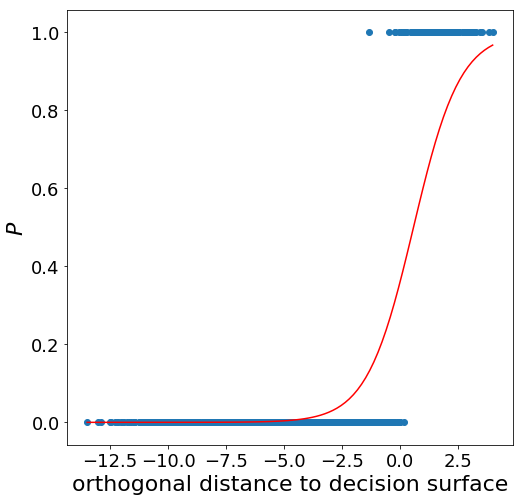

In [137]:
plt.scatter(regularizer_input, onehot_labels[:,i])
grid = np.linspace(np.min(regularizer_input), np.max(regularizer_input), 100)
plt.plot(grid, platt_regularizers[-1].predict_proba(grid.reshape(-1,1))[:,1], c='r')
plt.xlabel("orthogonal distance to decision surface", size=22)
plt.ylabel("$P$", size=22)
plt.savefig(

In [109]:
onehot_labels_test = mnist_onehotifier.transform(np.expand_dims(test_labels, 1)).toarray()
onehot_labels_test

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [105]:
test_Xy = test_predictions[i][0] - test_predictions[i][1]
test_Xy_len = np.sqrt(np.sum(test_Xy**2, axis=1))
test_pred = ovr_local_model.predict(test_data, kernel=kernel, r=kernel.support_radius())
regularizer_input_test = test_Xy_len*(test_pred[:,0] * 2 - 1)

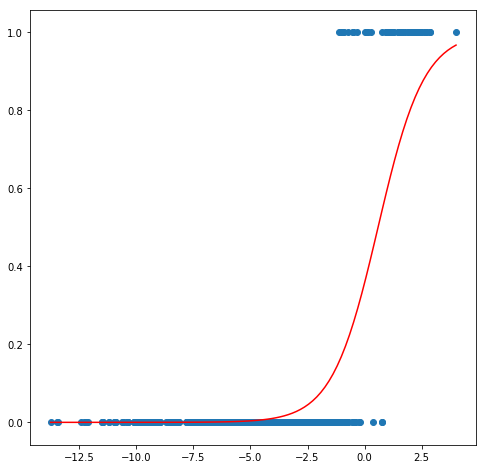

In [110]:
plt.scatter(regularizer_input_test, onehot_labels_test[:,i])
grid = np.linspace(np.min(regularizer_input_test), np.max(regularizer_input_test), 100)
plt.plot(grid, platt_regularizers[-1].predict_proba(grid.reshape(-1,1))[:,1], c='r')

In [114]:
regularized_output = []
for i, ovr_local_model in enumerate(ovr_local_models):
    print(i)
    test_Xy = test_predictions[i][0] - test_predictions[i][1]
    test_Xy_len = np.sqrt(np.sum(test_Xy**2, axis=1))
    test_pred = ovr_local_model.predict(test_data, kernel=kernel, r=kernel.support_radius())
    regularizer_input_test = test_Xy_len*(test_pred[:,0] * 2 - 1)
    regularized_output.append(platt_regularizers[i].predict_proba(regularizer_input_test.reshape(-1,1))[:,1])

0
1
2
3
4
5
6
7
8
9


In [115]:
regularized_output = np.stack(regularized_output, axis=-1)

In [116]:
regularized_output.shape

(540, 10)

In [117]:
test_data.shape

(540, 64)

In [118]:
regularized_output[0]

array([6.40067119e-05, 6.62691058e-01, 3.95226222e-03, 4.25242022e-05,
       1.98743614e-03, 5.10926684e-03, 2.81145165e-03, 6.17518944e-03,
       1.37953085e-01, 9.10014259e-03])

In [121]:
hard_predictions_test = np.argmax(regularized_output, axis=-1)

In [124]:
import sklearn.metrics
confusion_test = sklearn.metrics.confusion_matrix(test_labels, hard_predictions_test)
confusion_test

array([[57,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0, 46,  0,  0,  0,  1,  0,  0,  2,  0],
       [ 0,  1, 47,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 60,  0,  1,  0,  0,  1,  2],
       [ 0,  1,  0,  0, 60,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0, 44,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 56,  0,  1],
       [ 0,  1,  0,  0,  0,  1,  0,  0, 43,  1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  1, 55]])

In [130]:
accuracy, precision, recall = (
    sklearn.metrics.accuracy_score(test_labels, hard_predictions_test),
    sklearn.metrics.precision_score(test_labels, hard_predictions_test, average="macro"), 
    sklearn.metrics.recall_score(test_labels, hard_predictions_test, average="macro"))
accuracy, precision, recall

(0.9611111111111111, 0.9604548120811158, 0.9603488678480014)

In [160]:
np.savetxt(os.path.join(project_dir, "confusion"), confusion_test)
np.savetxt(os.path.join(project_dir, "acc_prec_rec"), np.array([accuracy, precision, recall]))

In [138]:
def nonorthopred_transformator(m,q,x,y,w):
    scores = m.decision_function(x)
    preds = m.predict(x)
    regularizer_features = scores*(preds*2-1)
    regularizer = sklearn.linear_model.LogisticRegression(C=1e-2, fit_intercept=False)
    regularizer.fit(regularizer_features.reshape(-1,1), y, sample_weight=w)
    return regularizer.predict_proba(m.decision_function(q.reshape(1,-1)).reshape(-1,1))

In [145]:
nonortho_proba_transformations = []
for i, ovr_local_model in enumerate(ovr_local_models):
    nonortho_proba_transformations.append(
        ovr_local_model.transform(test_data, kernel=kernel, r=kernel.support_radius(), weighted=True,
            model_postprocessor=nonorthopred_transformator))

In [147]:
nonortho_proba_transformations[0].shape

(540, 2)

In [148]:
nonortho_proba_transformations = np.stack(nonortho_proba_transformations, axis=-1)

In [149]:
nonortho_proba_transformations.shape

(540, 2, 10)

In [152]:
nonortho_hard_predictions = np.argmax(nonortho_proba_transformations[:,0], axis=-1)

In [153]:
nonortho_confusion = sklearn.metrics.confusion_matrix(test_labels, nonortho_hard_predictions)
nonortho_acc, nonortho_prec, nonortho_rec = (
    sklearn.metrics.accuracy_score(test_labels, nonortho_hard_predictions),
    sklearn.metrics.precision_score(test_labels, nonortho_hard_predictions, average="macro"), 
    sklearn.metrics.recall_score(test_labels, nonortho_hard_predictions, average="macro"))
nonortho_confusion, nonortho_acc, nonortho_prec, nonortho_rec

(array([[56,  0,  0,  0,  2,  0,  0,  1,  0,  0],
        [ 0, 46,  0,  0,  1,  1,  0,  0,  1,  0],
        [ 0,  1, 46,  1,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0, 61,  0,  1,  0,  0,  1,  1],
        [ 0,  2,  0,  0, 59,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  0,  0, 44,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 56,  0,  1],
        [ 0,  1,  0,  0,  0,  2,  0,  0, 42,  1],
        [ 0,  0,  0,  0,  0,  1,  0,  0,  1, 55]]),
 0.9555555555555556,
 0.9550921080334247,
 0.9543623789614604)

In [162]:
model_copy = sklearn.base.clone(model)

In [163]:
model_copy.fit(train_data, train_labels)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [164]:
linear_model_pred = model_copy.predict(test_data)

In [166]:
linear_model_confusion = sklearn.metrics.confusion_matrix(test_labels, linear_model_pred)
linear_model_acc, linear_model_prec, linear_model_rec = (
    sklearn.metrics.accuracy_score(test_labels, linear_model_pred),
    sklearn.metrics.precision_score(test_labels, linear_model_pred, average="macro"), 
    sklearn.metrics.recall_score(test_labels, linear_model_pred, average="macro"))
linear_model_confusion, linear_model_acc, linear_model_prec, linear_model_rec

(array([[57,  0,  0,  0,  2,  0,  0,  0,  0,  0],
        [ 0, 44,  0,  0,  0,  2,  0,  0,  3,  0],
        [ 0,  1, 46,  1,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0, 59,  0,  0,  0,  0,  3,  2],
        [ 0,  2,  0,  0, 59,  0,  0,  0,  0,  0],
        [ 0,  2,  0,  0,  0, 43,  0,  0,  0,  2],
        [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 56,  0,  1],
        [ 0,  0,  0,  0,  0,  1,  0,  0, 44,  1],
        [ 1,  0,  0,  0,  0,  1,  0,  0,  2, 53]]),
 0.9481481481481482,
 0.947307294072232,
 0.9475620561453001)